# YData Synthetic and Great Expectations: A Data Expectations Framework for a Synthetic Data Engine

This notebook is a step-by-step tutorial on how you can inetgrate the great expectations framework while working on a ydata-synthetic project.
Specifically we will
1. Setup the project structure by initializing a Data Context
2. Download/Extract the real data set which we use to create synthetic data
3. Configure a Data Source to connect our data
4. Create an Expectation Suite using the built-in Great Expectations profiler
5. Transform the real data for modeling
6. Train the synthesizers and create the model file
7. Sample synthetic data from synthesizer
8. Inverse transform the data to obtain the original format
9. Create a new checkpoint to validate the synthetic data against the real data
10. Evaluate the synthetic data using Data Docs 

But before we get started, ensure that you have installed both ydata-synthetic and great_expectations after creating a virtual environment.

!pip intsall ydata-synthetic great_expetctaions

## Step 1: Setup the project structure through a Data Context

In Great Expectations, your Data Context manages the project configuration. There are multiple ways to create the Data Context, however the simplest one is by using the CLI that comes along when you install the great_expectations package.

Note: For this tutorial we'll use the newest V3 (Batch request) API so youd see the flag ```--v3-api``` in most of the commands.

Open your terminal and navigate to the project directory and type in the following:

```great_expectations --v3-api init```

Press enter to complete the creation of the Data Context and that's about it.

If you're curious about the modified project structure, here's an excerpt from the GE documentations:
- great_expectations.yml contains the main configuration of your deployment.
- The expectations/ directory stores all your Expectations as JSON files. If you want to store them somewhere else, you can change that later.
- The plugins/ directory holds code for any custom plugins you develop as part of your deployment.
- The uncommitted/ directory contains files that shouldn’t live in version control. It has a .gitignore configured to exclude all its contents from version control. The main contents of the directory are:
    - uncommitted/config_variables.yml, which holds sensitive information, such as database credentials and other secrets.
    - uncommitted/documentation, which contains Data Docs generated from Expectations, Validation Results, and other metadata.
    - uncommitted/validations, which holds Validation Results generated by Great Expectations.

## Step 2: Download/Extract the real data set which we use to create synthetic data

To move forward, we pick an use-case example of "The Credit Card Fraud Dataset - Synthesizing the Minority Class" where we aim to synthesize the minority class of the credit card fraud dataset that has a high imbalance.Further a practical exercise is presented to showcase the usage of the YData Synthetic library along with
GANs to synthesize tabular data. For the purpose of this exercise, dataset of credit card fraud from Kaggle is used, that can be found here:
https://www.kaggle.com/mlg-ulb/creditcardfraud

Since we're interested only on the fraud class data points of the dataset, let's filter them and write it to teh data directory.

In [22]:
# importing all required libraries

import os
import pandas as pd
import sklearn.cluster as cluster

# from ydata_synthetic.synthesizers.regular import VanilllaGAN
from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.regular.credit_fraud import *
from ydata_synthetic.postprocessing.regular.inverse_preprocesser import inverse_transform

model = WGAN_GP

In [23]:
# Read the original data
data = pd.read_csv('./data/creditcard.csv')

#Filter the minority class
train_data = data.loc[ data['Class']==1 ].copy()

# Inspect the shape of the data
train_data.shape

(492, 31)

In [24]:
# Write to the data folder
train_data.to_csv('./data/creditcard_fraud.csv', index=False)

## Step 3: Configure a Data Source to connect our data

In Great Expectations, Datasources simplify connections, by managing configuration and providing a consistent, cross-platform API for referencing data.

Let’s configure our first Datasource: a connection to the data directory we’ve provided in the repo. Instead, this could even be a data base connection, and more.

```great_expectations --v3-api datasource new```

You would be presented with different options, select:
- 1. Files on a filesystem (for processing with Pandas or Spark) 

and for processing the data select


-  1. Pandas

and finally enter the directory as: data (where we have our real data)

Once you've entered the details an jupyter notebook will open up. This is just the way Great Expectations has given templated codes, which helps us create expectations with a few code changes.

Let's change the Datasource name to something more specific.

Edit the second code cell as follows:
```datasource_name = "data__dir"```

Then execute all cells in the notebook in order to save the new Datasource. If successful, the last cell will print a list of all Datasources, including the one you just created.

## Step 4: Create an Expectation Suite using the built-in Great Expectations profiler

An expectation is nothing but a falsifiable, verifiable statement about data. Expectations provide a language to talk about data characteristics and data quality - humans to humans, humans to machines, and machines to machines.

The idea here is that we assume that the real data has the ideal quality of the data we want to be synthesized, so we use the real data to create a set of expectations which we can later use to evaluate our synthetic data.

The CLI will help create our first Expectation Suite. Suites are simply collections of Expectations. We can use the built-in profiler to automatically create an Expectation Suite called `creditcard.quality`

Type the following into your terminal:
```great_expectations --v3-api suite new```

You would be presented with a few options on the terminal. Choose 3 to create the Expectation Suite Automatically, using a profiler, and 1 to profile the real fraud dataset creditcard_fraud.csv which we saved in step 2.

This step might be a bit confusing in the beginning but stay with us. Again another jupyter notebook would be opened with boilerplate code for creating a new expectation suite. The code is pretty standard, however, please note the second cell, all columns are added to the list of ignored columns. In our example we want to validate every single column, hence remove (or comment) out the columns from the ignored_columns list.

Other than that, go ahead and execute the entire notebook. This will create an expectation suite against the real credit card fraud dataset.

## Step 5: Transform the real data for modeling

Now that we have created the expectation suite, we shift our focus back to creating the synthetic data. We follow the standard process of transforming the data first.

In [25]:
# Extract list of columns
data_cols = list(data.columns[ data.columns != 'Class' ])

# Before training the GAN do not forget to apply the required data transformations
# To ease here we've applied a PowerTransformation - make data distribution more Gaussian-like.
_, data, preprocessor = transformations(data)

# For the purpose of this example we will only synthesize the minority class
# train_data contains 492 rows which had 'Class' value as 1 (which were very few)
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of variables - {}".format(train_data.shape[0], train_data.shape[1]))

# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 492 rows ('labels') having values either 0 or 1 for the 2 clustered classes.
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

# Get the count of both classes
print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of variables - 31
   count
0    384
1    108


In [26]:
train_data.shape

(492, 31)

# Step 6: Train the synthesizers and create the model

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remember that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [27]:
# Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 500
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
print("train_sample.columns:")
print(train_sample.columns)

# There's only 1 class, so essentially rename the 'Class' to 'Class_1',
# which tells weather a sample data is of class 1 or not.
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)

# 'Class_1' label
label_cols = [ i for i in train_sample.columns if 'Class' in i ]

# All columns except 'Class_1'
data_cols = [ i for i in train_sample.columns if i not in label_cols ]

# Scale down the data, and rename it to 'train_no_label'
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

train_sample.columns:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [28]:
#Setting the GAN model parameters and the training step parameters
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           n_cols=train_sample.shape[1],
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [29]:
# Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args, n_critic=2)
synthesizer.train(train_sample, train_args)

  1%|▋                                                                                 | 4/500 [00:01<01:47,  4.62it/s]

Epoch: 0 | disc_loss: 1.3900643587112427 | gen_loss: 0.0045707011595368385
Epoch: 1 | disc_loss: 0.08449796587228775 | gen_loss: 0.031327493488788605
Epoch: 2 | disc_loss: -0.040593791753053665 | gen_loss: 0.07145829498767853
Epoch: 3 | disc_loss: -0.009611748158931732 | gen_loss: 0.06341273337602615


  1%|▉                                                                                 | 6/500 [00:01<01:11,  6.91it/s]

Epoch: 4 | disc_loss: -0.03444388508796692 | gen_loss: 0.05271586403250694
Epoch: 5 | disc_loss: 0.013021789491176605 | gen_loss: 0.044850774109363556
Epoch: 6 | disc_loss: -0.038972511887550354 | gen_loss: 0.028071638196706772
Epoch: 7 | disc_loss: 0.11931518465280533 | gen_loss: 0.04252813011407852


  2%|█▉                                                                               | 12/500 [00:01<00:36, 13.24it/s]

Epoch: 8 | disc_loss: -0.05106820538640022 | gen_loss: 0.02461901679635048
Epoch: 9 | disc_loss: -0.04332617670297623 | gen_loss: 0.034593820571899414
Epoch: 10 | disc_loss: -0.01564370095729828 | gen_loss: 0.02591433934867382
Epoch: 11 | disc_loss: 0.01709357649087906 | gen_loss: 0.04142738878726959
Epoch: 12 | disc_loss: -0.04015436768531799 | gen_loss: 0.0537247397005558


  3%|██▌                                                                              | 16/500 [00:01<00:30, 15.65it/s]

Epoch: 13 | disc_loss: -0.04551912471652031 | gen_loss: 0.04289420321583748
Epoch: 14 | disc_loss: -0.020627988502383232 | gen_loss: 0.027804356068372726
Epoch: 15 | disc_loss: -0.035393811762332916 | gen_loss: 0.0353398472070694
Epoch: 16 | disc_loss: -0.01410762220621109 | gen_loss: 0.040031950920820236
Epoch: 17 | disc_loss: 0.04227292910218239 | gen_loss: 0.02096324972808361


  4%|███▍                                                                             | 21/500 [00:01<00:27, 17.30it/s]

Epoch: 18 | disc_loss: -0.005715332925319672 | gen_loss: 0.023008381947875023
Epoch: 19 | disc_loss: -0.025236766785383224 | gen_loss: 0.03550225868821144
Epoch: 20 | disc_loss: 0.015830498188734055 | gen_loss: 0.010646125301718712
Epoch: 21 | disc_loss: -0.048145584762096405 | gen_loss: 0.027631882578134537


  5%|████                                                                             | 25/500 [00:02<00:27, 17.17it/s]

Epoch: 22 | disc_loss: -0.025476321578025818 | gen_loss: 0.025138292461633682
Epoch: 23 | disc_loss: -0.0412670262157917 | gen_loss: 0.03930767625570297
Epoch: 24 | disc_loss: -0.02833767980337143 | gen_loss: 0.029343927279114723
Epoch: 25 | disc_loss: -0.040899720042943954 | gen_loss: 0.022084400057792664


  6%|████▋                                                                            | 29/500 [00:02<00:28, 16.72it/s]

Epoch: 26 | disc_loss: 0.01860101893544197 | gen_loss: 0.010496582835912704
Epoch: 27 | disc_loss: -0.038864027708768845 | gen_loss: 0.025830868631601334
Epoch: 28 | disc_loss: -0.029303040355443954 | gen_loss: 0.01837087795138359


  7%|█████▎                                                                           | 33/500 [00:02<00:28, 16.48it/s]

Epoch: 29 | disc_loss: -0.007753364741802216 | gen_loss: 0.006764734163880348
Epoch: 30 | disc_loss: 0.09653337299823761 | gen_loss: 0.027507780119776726
Epoch: 31 | disc_loss: 0.0024600625038146973 | gen_loss: 0.05032439902424812
Epoch: 32 | disc_loss: -0.0213189497590065 | gen_loss: 0.019658003002405167


  7%|█████▉                                                                           | 37/500 [00:02<00:26, 17.16it/s]

Epoch: 33 | disc_loss: -0.023201359435915947 | gen_loss: 0.03771991282701492
Epoch: 34 | disc_loss: -0.047666072845458984 | gen_loss: 0.03465753048658371
Epoch: 35 | disc_loss: -0.012007556855678558 | gen_loss: 0.031026849523186684
Epoch: 36 | disc_loss: 0.1009155660867691 | gen_loss: 0.04273161292076111


  8%|██████▊                                                                          | 42/500 [00:03<00:23, 19.09it/s]

Epoch: 37 | disc_loss: -0.012203656136989594 | gen_loss: 0.056589946150779724
Epoch: 38 | disc_loss: -0.039800260215997696 | gen_loss: 0.05520864576101303
Epoch: 39 | disc_loss: 0.06932762265205383 | gen_loss: 0.08032719790935516
Epoch: 40 | disc_loss: 0.01195315271615982 | gen_loss: 0.05494911968708038
Epoch: 41 | disc_loss: -0.02306850254535675 | gen_loss: 0.07383416593074799


  9%|███████▎                                                                         | 45/500 [00:03<00:22, 20.25it/s]

Epoch: 42 | disc_loss: -0.02754881978034973 | gen_loss: 0.06439406424760818
Epoch: 43 | disc_loss: -0.033252082765102386 | gen_loss: 0.06840822845697403
Epoch: 44 | disc_loss: -0.02041732147336006 | gen_loss: 0.04510117322206497
Epoch: 45 | disc_loss: -0.003989730030298233 | gen_loss: 0.05306993052363396
Epoch: 46 | disc_loss: -0.03369305282831192 | gen_loss: 0.06816566735506058


 10%|████████▎                                                                        | 51/500 [00:03<00:22, 19.85it/s]

Epoch: 47 | disc_loss: -0.03177665174007416 | gen_loss: 0.07883434742689133
Epoch: 48 | disc_loss: -0.012177154421806335 | gen_loss: 0.08374660462141037
Epoch: 49 | disc_loss: -0.03680119290947914 | gen_loss: 0.0756651982665062
Epoch: 50 | disc_loss: -0.025125551968812943 | gen_loss: 0.08034028112888336
Epoch: 51 | disc_loss: 0.02960110455751419 | gen_loss: 0.08441516757011414


 11%|█████████▏                                                                       | 57/500 [00:03<00:23, 19.07it/s]

Epoch: 52 | disc_loss: 0.04470663517713547 | gen_loss: 0.08835730701684952
Epoch: 53 | disc_loss: -0.0400683730840683 | gen_loss: 0.06857961416244507
Epoch: 54 | disc_loss: -0.021724000573158264 | gen_loss: 0.10225216299295425
Epoch: 55 | disc_loss: -0.026060141623020172 | gen_loss: 0.08351147174835205
Epoch: 56 | disc_loss: -0.03382696211338043 | gen_loss: 0.10043375194072723


 12%|█████████▉                                                                       | 61/500 [00:04<00:24, 18.18it/s]

Epoch: 57 | disc_loss: -0.027746066451072693 | gen_loss: 0.07306496798992157
Epoch: 58 | disc_loss: -0.010261215269565582 | gen_loss: 0.10517184436321259
Epoch: 59 | disc_loss: 0.08637970685958862 | gen_loss: 0.08333040773868561
Epoch: 60 | disc_loss: -0.014238189905881882 | gen_loss: 0.08210130035877228


 13%|██████████▏                                                                      | 63/500 [00:04<00:23, 18.44it/s]

Epoch: 61 | disc_loss: -0.03720521926879883 | gen_loss: 0.11803966760635376
Epoch: 62 | disc_loss: -0.015188910067081451 | gen_loss: 0.10072857141494751
Epoch: 63 | disc_loss: -0.03805745393037796 | gen_loss: 0.09134647250175476
Epoch: 64 | disc_loss: -0.03013075888156891 | gen_loss: 0.11521684378385544


 14%|███████████                                                                      | 68/500 [00:04<00:23, 18.66it/s]

Epoch: 65 | disc_loss: -0.03501776605844498 | gen_loss: 0.1075054332613945
Epoch: 66 | disc_loss: -0.03402232751250267 | gen_loss: 0.09597112238407135
Epoch: 67 | disc_loss: -0.023707356303930283 | gen_loss: 0.11076769232749939
Epoch: 68 | disc_loss: -0.012253234162926674 | gen_loss: 0.11331374943256378
Epoch: 69 | disc_loss: -0.017802705988287926 | gen_loss: 0.09729037433862686


 15%|███████████▉                                                                     | 74/500 [00:04<00:21, 20.10it/s]

Epoch: 70 | disc_loss: 0.10718084126710892 | gen_loss: 0.11094164848327637
Epoch: 71 | disc_loss: -0.02643822878599167 | gen_loss: 0.07803471386432648
Epoch: 72 | disc_loss: -0.021564632654190063 | gen_loss: 0.10189507156610489
Epoch: 73 | disc_loss: 0.031278617680072784 | gen_loss: 0.10017608851194382
Epoch: 74 | disc_loss: -0.005309479311108589 | gen_loss: 0.10224633663892746


 16%|████████████▉                                                                    | 80/500 [00:05<00:20, 20.70it/s]

Epoch: 75 | disc_loss: -0.03155236691236496 | gen_loss: 0.08967158198356628
Epoch: 76 | disc_loss: -0.020696789026260376 | gen_loss: 0.10114417970180511
Epoch: 77 | disc_loss: -0.014623809605836868 | gen_loss: 0.11048208922147751
Epoch: 78 | disc_loss: -0.02586129866540432 | gen_loss: 0.09265054762363434
Epoch: 79 | disc_loss: 0.011672962456941605 | gen_loss: 0.10791733860969543


 17%|█████████████▍                                                                   | 83/500 [00:05<00:19, 21.15it/s]

Epoch: 80 | disc_loss: 0.0027820486575365067 | gen_loss: 0.0960196927189827
Epoch: 81 | disc_loss: -0.012376351282000542 | gen_loss: 0.09647936373949051
Epoch: 82 | disc_loss: -0.010647047311067581 | gen_loss: 0.11477745324373245
Epoch: 83 | disc_loss: -0.02586241438984871 | gen_loss: 0.09775176644325256
Epoch: 84 | disc_loss: -0.033847782760858536 | gen_loss: 0.10002386569976807


 18%|██████████████▍                                                                  | 89/500 [00:05<00:18, 21.75it/s]

Epoch: 85 | disc_loss: -0.026955053210258484 | gen_loss: 0.10890430212020874
Epoch: 86 | disc_loss: 0.0022689364850521088 | gen_loss: 0.10340509563684464
Epoch: 87 | disc_loss: 0.022044871002435684 | gen_loss: 0.09024709463119507
Epoch: 88 | disc_loss: 0.12766814231872559 | gen_loss: 0.11644815653562546
Epoch: 89 | disc_loss: -0.015497563406825066 | gen_loss: 0.09713045507669449


 19%|███████████████▍                                                                 | 95/500 [00:05<00:18, 22.11it/s]

Epoch: 90 | disc_loss: -0.02580714225769043 | gen_loss: 0.11645698547363281
Epoch: 91 | disc_loss: 0.026863008737564087 | gen_loss: 0.08855825662612915
Epoch: 92 | disc_loss: -0.02189822867512703 | gen_loss: 0.10831920802593231
Epoch: 93 | disc_loss: 0.016810134053230286 | gen_loss: 0.11241665482521057
Epoch: 94 | disc_loss: -0.03161541745066643 | gen_loss: 0.11570567637681961


 20%|███████████████▉                                                                 | 98/500 [00:05<00:18, 21.73it/s]

Epoch: 95 | disc_loss: -0.010672204196453094 | gen_loss: 0.10965050011873245
Epoch: 96 | disc_loss: -0.00572194904088974 | gen_loss: 0.11269740760326385
Epoch: 97 | disc_loss: -0.022576915100216866 | gen_loss: 0.09753488004207611
Epoch: 98 | disc_loss: -0.018445849418640137 | gen_loss: 0.10152968019247055


 20%|████████████████▏                                                               | 101/500 [00:06<00:20, 19.47it/s]

Epoch: 99 | disc_loss: -0.0008646901696920395 | gen_loss: 0.09428690373897552
Epoch: 100 | disc_loss: -0.02522170916199684 | gen_loss: 0.09708999842405319
Epoch: 101 | disc_loss: 0.06350726634263992 | gen_loss: 0.10830725729465485
Epoch: 102 | disc_loss: -0.021187515929341316 | gen_loss: 0.08033148944377899


 21%|█████████████████                                                               | 107/500 [00:06<00:19, 19.82it/s]

Epoch: 103 | disc_loss: -0.01900278404355049 | gen_loss: 0.101561538875103
Epoch: 104 | disc_loss: 0.0008167102932929993 | gen_loss: 0.09965222328901291
Epoch: 105 | disc_loss: -0.02951119840145111 | gen_loss: 0.08668380975723267
Epoch: 106 | disc_loss: 0.0039071813225746155 | gen_loss: 0.09906221926212311
Epoch: 107 | disc_loss: 0.0028250031173229218 | gen_loss: 0.10054011642932892


 22%|█████████████████▉                                                              | 112/500 [00:06<00:19, 19.53it/s]

Epoch: 108 | disc_loss: -0.03139788657426834 | gen_loss: 0.0986689031124115
Epoch: 109 | disc_loss: -0.03155839443206787 | gen_loss: 0.07701214402914047
Epoch: 110 | disc_loss: -0.03370436280965805 | gen_loss: 0.09120602905750275
Epoch: 111 | disc_loss: -0.024472415447235107 | gen_loss: 0.08926484733819962
Epoch: 112 | disc_loss: -0.027191149070858955 | gen_loss: 0.09374543279409409


 24%|██████████████████▉                                                             | 118/500 [00:06<00:18, 20.13it/s]

Epoch: 113 | disc_loss: -0.03531204164028168 | gen_loss: 0.09846941381692886
Epoch: 114 | disc_loss: -0.02651451714336872 | gen_loss: 0.08648988604545593
Epoch: 115 | disc_loss: -0.026576682925224304 | gen_loss: 0.0825667679309845
Epoch: 116 | disc_loss: -0.031862255185842514 | gen_loss: 0.08482907712459564
Epoch: 117 | disc_loss: -0.031905774027109146 | gen_loss: 0.10222004354000092


 24%|███████████████████▎                                                            | 121/500 [00:07<00:19, 19.48it/s]

Epoch: 118 | disc_loss: -0.02625676617026329 | gen_loss: 0.09996026754379272
Epoch: 119 | disc_loss: 0.16170485317707062 | gen_loss: 0.09650762379169464
Epoch: 120 | disc_loss: -0.026526883244514465 | gen_loss: 0.07733254134654999
Epoch: 121 | disc_loss: -0.01741057261824608 | gen_loss: 0.08140499889850616


 25%|████████████████████▎                                                           | 127/500 [00:07<00:18, 20.39it/s]

Epoch: 122 | disc_loss: -0.0247872956097126 | gen_loss: 0.08834986388683319
Epoch: 123 | disc_loss: -0.026445986703038216 | gen_loss: 0.10472514480352402
Epoch: 124 | disc_loss: -0.016130562871694565 | gen_loss: 0.10770927369594574
Epoch: 125 | disc_loss: -0.03168485686182976 | gen_loss: 0.10143018513917923
Epoch: 126 | disc_loss: -0.03023245930671692 | gen_loss: 0.1105094850063324


 26%|████████████████████▊                                                           | 130/500 [00:07<00:17, 20.66it/s]

Epoch: 127 | disc_loss: -0.032182879745960236 | gen_loss: 0.10441380739212036
Epoch: 128 | disc_loss: -0.014449596405029297 | gen_loss: 0.11205657571554184
Epoch: 129 | disc_loss: -0.026751672849059105 | gen_loss: 0.09947981685400009
Epoch: 130 | disc_loss: -0.012413576245307922 | gen_loss: 0.08855785429477692
Epoch: 131 | disc_loss: -0.031232478097081184 | gen_loss: 0.0873892679810524


 27%|█████████████████████▊                                                          | 136/500 [00:07<00:17, 20.69it/s]

Epoch: 132 | disc_loss: -0.029390616342425346 | gen_loss: 0.09746013581752777
Epoch: 133 | disc_loss: -0.016901647672057152 | gen_loss: 0.09673301875591278
Epoch: 134 | disc_loss: -0.033179737627506256 | gen_loss: 0.0956745594739914
Epoch: 135 | disc_loss: -0.007609197869896889 | gen_loss: 0.09564332664012909
Epoch: 136 | disc_loss: -0.01756003126502037 | gen_loss: 0.09209480881690979


 28%|██████████████████████▋                                                         | 142/500 [00:08<00:17, 20.73it/s]

Epoch: 137 | disc_loss: 0.09968604147434235 | gen_loss: 0.08269800990819931
Epoch: 138 | disc_loss: -0.03630582615733147 | gen_loss: 0.09322859346866608
Epoch: 139 | disc_loss: -0.029474852606654167 | gen_loss: 0.10166455805301666
Epoch: 140 | disc_loss: -0.033578045666217804 | gen_loss: 0.09191165864467621
Epoch: 141 | disc_loss: -0.03208574652671814 | gen_loss: 0.08341435343027115


 29%|███████████████████████▏                                                        | 145/500 [00:08<00:16, 20.98it/s]

Epoch: 142 | disc_loss: -0.03340280055999756 | gen_loss: 0.06993397325277328
Epoch: 143 | disc_loss: 0.025155827403068542 | gen_loss: 0.08858320116996765
Epoch: 144 | disc_loss: -0.036612555384635925 | gen_loss: 0.08483803272247314
Epoch: 145 | disc_loss: 0.019381128251552582 | gen_loss: 0.08926930278539658
Epoch: 146 | disc_loss: -0.022340066730976105 | gen_loss: 0.08655411750078201


 30%|████████████████████████▏                                                       | 151/500 [00:08<00:16, 21.10it/s]

Epoch: 147 | disc_loss: -0.01498723030090332 | gen_loss: 0.08425544202327728
Epoch: 148 | disc_loss: -0.009164972230792046 | gen_loss: 0.09746937453746796
Epoch: 149 | disc_loss: -0.02525033801794052 | gen_loss: 0.0988909900188446
Epoch: 150 | disc_loss: 0.02406599000096321 | gen_loss: 0.09711377322673798
Epoch: 151 | disc_loss: -0.02498648874461651 | gen_loss: 0.09351201355457306


 31%|█████████████████████████                                                       | 157/500 [00:08<00:15, 21.56it/s]

Epoch: 152 | disc_loss: -0.02805135026574135 | gen_loss: 0.09769100695848465
Epoch: 153 | disc_loss: -0.00216645747423172 | gen_loss: 0.10017989575862885
Epoch: 154 | disc_loss: -0.03277885168790817 | gen_loss: 0.0999155342578888
Epoch: 155 | disc_loss: -0.0220811665058136 | gen_loss: 0.11133308708667755
Epoch: 156 | disc_loss: -0.008793054148554802 | gen_loss: 0.10008293390274048


 32%|█████████████████████████▌                                                      | 160/500 [00:08<00:15, 21.57it/s]

Epoch: 157 | disc_loss: -0.023550061509013176 | gen_loss: 0.09376400709152222
Epoch: 158 | disc_loss: -0.03262872248888016 | gen_loss: 0.08451707661151886
Epoch: 159 | disc_loss: -0.032744407653808594 | gen_loss: 0.08781260251998901
Epoch: 160 | disc_loss: -0.015098284929990768 | gen_loss: 0.08723300695419312
Epoch: 161 | disc_loss: -0.03600022569298744 | gen_loss: 0.08952776342630386


 33%|██████████████████████████▌                                                     | 166/500 [00:09<00:16, 20.62it/s]

Epoch: 162 | disc_loss: -0.02676760032773018 | gen_loss: 0.08557791262865067
Epoch: 163 | disc_loss: -0.03629987686872482 | gen_loss: 0.10700970888137817
Epoch: 164 | disc_loss: -0.0020430199801921844 | gen_loss: 0.08394236862659454
Epoch: 165 | disc_loss: 0.036823127418756485 | gen_loss: 0.07939516007900238
Epoch: 166 | disc_loss: -0.0324869230389595 | gen_loss: 0.08698545396327972


 34%|███████████████████████████▌                                                    | 172/500 [00:09<00:15, 20.85it/s]

Epoch: 167 | disc_loss: -0.03364505618810654 | gen_loss: 0.09233856946229935
Epoch: 168 | disc_loss: -0.03116810880601406 | gen_loss: 0.08789998292922974
Epoch: 169 | disc_loss: -0.03302968665957451 | gen_loss: 0.07817700505256653
Epoch: 170 | disc_loss: -0.029063573107123375 | gen_loss: 0.07721565663814545
Epoch: 171 | disc_loss: -0.025160450488328934 | gen_loss: 0.07538966834545135


 35%|████████████████████████████                                                    | 175/500 [00:09<00:15, 21.42it/s]

Epoch: 172 | disc_loss: -0.02840888500213623 | gen_loss: 0.0813397467136383
Epoch: 173 | disc_loss: -0.026240412145853043 | gen_loss: 0.0831981897354126
Epoch: 174 | disc_loss: -0.023024236783385277 | gen_loss: 0.07876470685005188
Epoch: 175 | disc_loss: -0.012385647743940353 | gen_loss: 0.0906696617603302
Epoch: 176 | disc_loss: -0.03539440780878067 | gen_loss: 0.07203631103038788


 36%|████████████████████████████▉                                                   | 181/500 [00:09<00:15, 21.19it/s]

Epoch: 177 | disc_loss: -0.014282340183854103 | gen_loss: 0.07544964551925659
Epoch: 178 | disc_loss: -0.015062537044286728 | gen_loss: 0.071926049888134
Epoch: 179 | disc_loss: -0.02448895014822483 | gen_loss: 0.08672273904085159
Epoch: 180 | disc_loss: -0.02103055827319622 | gen_loss: 0.08396825194358826
Epoch: 181 | disc_loss: -0.029255207628011703 | gen_loss: 0.0748743861913681


 37%|█████████████████████████████▍                                                  | 184/500 [00:10<00:15, 20.69it/s]

Epoch: 182 | disc_loss: -0.02951302006840706 | gen_loss: 0.07065685838460922
Epoch: 183 | disc_loss: 0.0005871020257472992 | gen_loss: 0.08001674711704254
Epoch: 184 | disc_loss: -0.02145383134484291 | gen_loss: 0.06239372864365578
Epoch: 185 | disc_loss: -0.028577936813235283 | gen_loss: 0.06886190176010132


 38%|██████████████████████████████▍                                                 | 190/500 [00:10<00:15, 20.43it/s]

Epoch: 186 | disc_loss: -0.02500256337225437 | gen_loss: 0.06989622116088867
Epoch: 187 | disc_loss: -0.02482558786869049 | gen_loss: 0.07935662567615509
Epoch: 188 | disc_loss: -0.035078924149274826 | gen_loss: 0.07813789695501328
Epoch: 189 | disc_loss: -0.03565837815403938 | gen_loss: 0.0645723044872284
Epoch: 190 | disc_loss: -0.025507958605885506 | gen_loss: 0.0818299725651741


 39%|███████████████████████████████▎                                                | 196/500 [00:10<00:14, 20.95it/s]

Epoch: 191 | disc_loss: -0.03239569440484047 | gen_loss: 0.07201771438121796
Epoch: 192 | disc_loss: -0.02698647975921631 | gen_loss: 0.059279125183820724
Epoch: 193 | disc_loss: 0.005597718060016632 | gen_loss: 0.06967486441135406
Epoch: 194 | disc_loss: -0.028944212943315506 | gen_loss: 0.07825376093387604
Epoch: 195 | disc_loss: -0.026986870914697647 | gen_loss: 0.06977881491184235


 40%|███████████████████████████████▊                                                | 199/500 [00:10<00:14, 20.91it/s]

Epoch: 196 | disc_loss: -0.04326764866709709 | gen_loss: 0.08166420459747314
Epoch: 197 | disc_loss: -0.020455252379179 | gen_loss: 0.07681797444820404
Epoch: 198 | disc_loss: -0.01862381398677826 | gen_loss: 0.07206778228282928
Epoch: 199 | disc_loss: 0.05232391878962517 | gen_loss: 0.065773606300354
Epoch: 200 | disc_loss: -0.03053263947367668 | gen_loss: 0.06807583570480347


 41%|████████████████████████████████▊                                               | 205/500 [00:11<00:15, 19.66it/s]

Epoch: 201 | disc_loss: -0.028856242075562477 | gen_loss: 0.06571619212627411
Epoch: 202 | disc_loss: -0.03672448545694351 | gen_loss: 0.08123588562011719
Epoch: 203 | disc_loss: -0.015166650526225567 | gen_loss: 0.06969684362411499
Epoch: 204 | disc_loss: -0.02161867544054985 | gen_loss: 0.07064255326986313


 42%|█████████████████████████████████▍                                              | 209/500 [00:11<00:15, 19.25it/s]

Epoch: 205 | disc_loss: -0.031269371509552 | gen_loss: 0.06380434334278107
Epoch: 206 | disc_loss: -0.030906278640031815 | gen_loss: 0.0639587789773941
Epoch: 207 | disc_loss: -0.03477396070957184 | gen_loss: 0.06502573937177658
Epoch: 208 | disc_loss: -0.03736519441008568 | gen_loss: 0.0697348415851593


 43%|██████████████████████████████████                                              | 213/500 [00:11<00:15, 18.42it/s]

Epoch: 209 | disc_loss: -0.006870556622743607 | gen_loss: 0.08706687390804291
Epoch: 210 | disc_loss: -0.020991042256355286 | gen_loss: 0.0747813880443573
Epoch: 211 | disc_loss: -0.009510181844234467 | gen_loss: 0.06342440843582153
Epoch: 212 | disc_loss: -0.03035290725529194 | gen_loss: 0.06737811863422394


 43%|██████████████████████████████████▋                                             | 217/500 [00:11<00:16, 17.33it/s]

Epoch: 213 | disc_loss: -0.021699324250221252 | gen_loss: 0.0680525079369545
Epoch: 214 | disc_loss: -0.03278081491589546 | gen_loss: 0.07275745272636414
Epoch: 215 | disc_loss: -0.012489375658333302 | gen_loss: 0.06973330676555634
Epoch: 216 | disc_loss: 0.083961620926857 | gen_loss: 0.056337956339120865


 44%|███████████████████████████████████▌                                            | 222/500 [00:12<00:14, 18.85it/s]

Epoch: 217 | disc_loss: -0.019315754994750023 | gen_loss: 0.06651391088962555
Epoch: 218 | disc_loss: -0.031421300023794174 | gen_loss: 0.06452648341655731
Epoch: 219 | disc_loss: -0.017529677599668503 | gen_loss: 0.0585954412817955
Epoch: 220 | disc_loss: -0.03214159235358238 | gen_loss: 0.07383857667446136
Epoch: 221 | disc_loss: 0.00033058226108551025 | gen_loss: 0.06639347225427628


 45%|████████████████████████████████████▏                                           | 226/500 [00:12<00:14, 18.96it/s]

Epoch: 222 | disc_loss: -0.026926087215542793 | gen_loss: 0.06966592371463776
Epoch: 223 | disc_loss: -0.030628161504864693 | gen_loss: 0.07082884013652802
Epoch: 224 | disc_loss: -0.0211721733212471 | gen_loss: 0.055408064275979996
Epoch: 225 | disc_loss: -0.028419189155101776 | gen_loss: 0.06382177025079727


 46%|████████████████████████████████████▊                                           | 230/500 [00:12<00:14, 19.01it/s]

Epoch: 226 | disc_loss: 0.02915419265627861 | gen_loss: 0.06643357872962952
Epoch: 227 | disc_loss: -0.011044500395655632 | gen_loss: 0.05763716995716095
Epoch: 228 | disc_loss: -0.027324069291353226 | gen_loss: 0.07578472048044205
Epoch: 229 | disc_loss: -0.033485639840364456 | gen_loss: 0.07245717197656631
Epoch: 230 | disc_loss: -0.020808815956115723 | gen_loss: 0.06581683456897736


 47%|█████████████████████████████████████▌                                          | 235/500 [00:12<00:13, 19.62it/s]

Epoch: 231 | disc_loss: 0.01852267235517502 | gen_loss: 0.06472284346818924
Epoch: 232 | disc_loss: -0.03332368656992912 | gen_loss: 0.05889108031988144
Epoch: 233 | disc_loss: -0.03057095967233181 | gen_loss: 0.061412736773490906
Epoch: 234 | disc_loss: -0.021009067073464394 | gen_loss: 0.04816365987062454
Epoch: 235 | disc_loss: 0.013035252690315247 | gen_loss: 0.055236637592315674


 48%|██████████████████████████████████████▍                                         | 240/500 [00:12<00:13, 19.86it/s]

Epoch: 236 | disc_loss: -0.028688479214906693 | gen_loss: 0.05230783671140671
Epoch: 237 | disc_loss: -0.03653675690293312 | gen_loss: 0.06104149669408798
Epoch: 238 | disc_loss: -0.015395376831293106 | gen_loss: 0.050963543355464935
Epoch: 239 | disc_loss: -0.019489435479044914 | gen_loss: 0.051921483129262924
Epoch: 240 | disc_loss: -0.017584603279829025 | gen_loss: 0.043668217957019806


 49%|███████████████████████████████████████                                         | 244/500 [00:13<00:12, 19.78it/s]

Epoch: 241 | disc_loss: -0.0314948596060276 | gen_loss: 0.059025801718235016
Epoch: 242 | disc_loss: 0.005532730370759964 | gen_loss: 0.055853426456451416
Epoch: 243 | disc_loss: -0.00802561454474926 | gen_loss: 0.06290270388126373
Epoch: 244 | disc_loss: -0.024501437321305275 | gen_loss: 0.05569273233413696
Epoch: 245 | disc_loss: -0.029572702944278717 | gen_loss: 0.05234495550394058


 50%|████████████████████████████████████████                                        | 250/500 [00:13<00:12, 19.85it/s]

Epoch: 246 | disc_loss: -0.022191006690263748 | gen_loss: 0.04402188956737518
Epoch: 247 | disc_loss: 0.047040294855833054 | gen_loss: 0.04749316722154617
Epoch: 248 | disc_loss: -0.01975245773792267 | gen_loss: 0.05310618504881859
Epoch: 249 | disc_loss: -0.02813149057328701 | gen_loss: 0.045243650674819946
Epoch: 250 | disc_loss: -0.031922098249197006 | gen_loss: 0.047572262585163116


 51%|████████████████████████████████████████▉                                       | 256/500 [00:13<00:12, 20.30it/s]

Epoch: 251 | disc_loss: -0.02680741809308529 | gen_loss: 0.04738915339112282
Epoch: 252 | disc_loss: -0.014799349009990692 | gen_loss: 0.052450746297836304
Epoch: 253 | disc_loss: -0.031893398612737656 | gen_loss: 0.052280720323324203
Epoch: 254 | disc_loss: -0.03136469051241875 | gen_loss: 0.05443466454744339
Epoch: 255 | disc_loss: -0.024276386946439743 | gen_loss: 0.05102978274226189


 52%|█████████████████████████████████████████▍                                      | 259/500 [00:13<00:11, 20.57it/s]

Epoch: 256 | disc_loss: -0.029099876061081886 | gen_loss: 0.051042795181274414
Epoch: 257 | disc_loss: -0.024680715054273605 | gen_loss: 0.05773879960179329
Epoch: 258 | disc_loss: -0.029749957844614983 | gen_loss: 0.052513256669044495
Epoch: 259 | disc_loss: -0.03522157669067383 | gen_loss: 0.073470339179039
Epoch: 260 | disc_loss: -0.019020339474081993 | gen_loss: 0.07278300821781158


 53%|██████████████████████████████████████████▍                                     | 265/500 [00:14<00:11, 19.95it/s]

Epoch: 261 | disc_loss: -0.034571271389722824 | gen_loss: 0.05995957925915718
Epoch: 262 | disc_loss: -0.020878303796052933 | gen_loss: 0.05215522646903992
Epoch: 263 | disc_loss: -0.01645522192120552 | gen_loss: 0.043039534240961075
Epoch: 264 | disc_loss: -0.02863393723964691 | gen_loss: 0.03965551406145096
Epoch: 265 | disc_loss: -0.021330304443836212 | gen_loss: 0.053882960230112076


 54%|███████████████████████████████████████████                                     | 269/500 [00:14<00:11, 19.44it/s]

Epoch: 266 | disc_loss: -0.02774864062666893 | gen_loss: 0.053448040038347244
Epoch: 267 | disc_loss: 0.006578855216503143 | gen_loss: 0.061487674713134766
Epoch: 268 | disc_loss: -0.01322738267481327 | gen_loss: 0.04326491430401802
Epoch: 269 | disc_loss: -0.004624340683221817 | gen_loss: 0.05109758675098419
Epoch: 270 | disc_loss: -0.008801493793725967 | gen_loss: 0.05678905174136162


 55%|████████████████████████████████████████████                                    | 275/500 [00:14<00:11, 20.08it/s]

Epoch: 271 | disc_loss: -0.005413185805082321 | gen_loss: 0.05840516835451126
Epoch: 272 | disc_loss: -0.01759161800146103 | gen_loss: 0.0759001225233078
Epoch: 273 | disc_loss: 0.007278483361005783 | gen_loss: 0.05792860686779022
Epoch: 274 | disc_loss: -0.010217661038041115 | gen_loss: 0.06476907432079315
Epoch: 275 | disc_loss: -0.029015908017754555 | gen_loss: 0.06215004250407219


 56%|████████████████████████████████████████████▉                                   | 281/500 [00:15<00:10, 20.38it/s]

Epoch: 276 | disc_loss: -0.0011236406862735748 | gen_loss: 0.05269917473196983
Epoch: 277 | disc_loss: -0.03127729892730713 | gen_loss: 0.06783337891101837
Epoch: 278 | disc_loss: -0.030934303998947144 | gen_loss: 0.06323128938674927
Epoch: 279 | disc_loss: -0.02805269882082939 | gen_loss: 0.05218478664755821
Epoch: 280 | disc_loss: -0.03224816173315048 | gen_loss: 0.04581698030233383


 57%|█████████████████████████████████████████████▍                                  | 284/500 [00:15<00:10, 20.22it/s]

Epoch: 281 | disc_loss: -0.0070094820111989975 | gen_loss: 0.06875775009393692
Epoch: 282 | disc_loss: -0.02081669494509697 | gen_loss: 0.054516419768333435
Epoch: 283 | disc_loss: -0.02297414094209671 | gen_loss: 0.05075549706816673
Epoch: 284 | disc_loss: -0.02906477265059948 | gen_loss: 0.06863756477832794
Epoch: 285 | disc_loss: -0.029381876811385155 | gen_loss: 0.05722856521606445


 58%|██████████████████████████████████████████████▏                                 | 289/500 [00:15<00:10, 19.71it/s]

Epoch: 286 | disc_loss: 0.00496310368180275 | gen_loss: 0.03939086198806763
Epoch: 287 | disc_loss: -0.03264864534139633 | gen_loss: 0.05470836162567139
Epoch: 288 | disc_loss: -0.023593299090862274 | gen_loss: 0.0463908426463604
Epoch: 289 | disc_loss: 0.07146847248077393 | gen_loss: 0.05019687861204147
Epoch: 290 | disc_loss: -0.003272872418165207 | gen_loss: 0.040990572422742844


 59%|███████████████████████████████████████████████▏                                | 295/500 [00:15<00:10, 20.07it/s]

Epoch: 291 | disc_loss: -0.020245123654603958 | gen_loss: 0.054097749292850494
Epoch: 292 | disc_loss: -0.0306338369846344 | gen_loss: 0.053699567914009094
Epoch: 293 | disc_loss: -0.027744971215724945 | gen_loss: 0.05173072963953018
Epoch: 294 | disc_loss: -0.0187312513589859 | gen_loss: 0.058757007122039795
Epoch: 295 | disc_loss: -0.015926441177725792 | gen_loss: 0.04745864495635033


 60%|███████████████████████████████████████████████▋                                | 298/500 [00:15<00:10, 20.18it/s]

Epoch: 296 | disc_loss: -0.02229202724993229 | gen_loss: 0.05189342051744461
Epoch: 297 | disc_loss: 0.003792423754930496 | gen_loss: 0.051616739481687546
Epoch: 298 | disc_loss: 0.020176440477371216 | gen_loss: 0.04523021727800369
Epoch: 299 | disc_loss: -0.031523462384939194 | gen_loss: 0.038651637732982635
Epoch: 300 | disc_loss: -0.017635934054851532 | gen_loss: 0.04115676134824753


 61%|████████████████████████████████████████████████▊                               | 305/500 [00:16<00:10, 19.44it/s]

Epoch: 301 | disc_loss: -0.0031546149402856827 | gen_loss: 0.0464794784784317
Epoch: 302 | disc_loss: -0.031637560576200485 | gen_loss: 0.047603264451026917
Epoch: 303 | disc_loss: -0.030412552878260612 | gen_loss: 0.04279506579041481
Epoch: 304 | disc_loss: -0.02675556391477585 | gen_loss: 0.03938502445816994


 62%|█████████████████████████████████████████████████▍                              | 309/500 [00:16<00:10, 18.95it/s]

Epoch: 305 | disc_loss: -0.015177426859736443 | gen_loss: 0.04920642077922821
Epoch: 306 | disc_loss: -0.012644710019230843 | gen_loss: 0.05776258558034897
Epoch: 307 | disc_loss: 0.008116088807582855 | gen_loss: 0.0482187420129776
Epoch: 308 | disc_loss: -0.02886785939335823 | gen_loss: 0.05378514900803566


 63%|██████████████████████████████████████████████████▏                             | 314/500 [00:16<00:09, 19.55it/s]

Epoch: 309 | disc_loss: -0.029387444257736206 | gen_loss: 0.060417696833610535
Epoch: 310 | disc_loss: -0.03652406856417656 | gen_loss: 0.056489624083042145
Epoch: 311 | disc_loss: -0.0332074835896492 | gen_loss: 0.05512244254350662
Epoch: 312 | disc_loss: -0.0008970852941274643 | gen_loss: 0.04798668995499611
Epoch: 313 | disc_loss: 0.005599759519100189 | gen_loss: 0.05293849855661392


 63%|██████████████████████████████████████████████████▋                             | 317/500 [00:16<00:09, 19.88it/s]

Epoch: 314 | disc_loss: 0.004721686244010925 | gen_loss: 0.050408735871315
Epoch: 315 | disc_loss: -0.023789282888174057 | gen_loss: 0.04456315189599991
Epoch: 316 | disc_loss: -0.035176847130060196 | gen_loss: 0.056527912616729736
Epoch: 317 | disc_loss: -0.019374534487724304 | gen_loss: 0.062156565487384796
Epoch: 318 | disc_loss: -0.02256741374731064 | gen_loss: 0.054715435951948166


 64%|███████████████████████████████████████████████████▌                            | 322/500 [00:17<00:09, 19.76it/s]

Epoch: 319 | disc_loss: 0.029698997735977173 | gen_loss: 0.05431176722049713
Epoch: 320 | disc_loss: -0.015998296439647675 | gen_loss: 0.05021512508392334
Epoch: 321 | disc_loss: -0.03259889781475067 | gen_loss: 0.04871683195233345
Epoch: 322 | disc_loss: -0.028089623898267746 | gen_loss: 0.044532425701618195
Epoch: 323 | disc_loss: -0.03055303916335106 | gen_loss: 0.05544699355959892


 66%|████████████████████████████████████████████████████▋                           | 329/500 [00:17<00:08, 19.50it/s]

Epoch: 324 | disc_loss: -0.012289902195334435 | gen_loss: 0.046792663633823395
Epoch: 325 | disc_loss: 0.0028809793293476105 | gen_loss: 0.04059873893857002
Epoch: 326 | disc_loss: -0.008972061797976494 | gen_loss: 0.03682486712932587
Epoch: 327 | disc_loss: -0.015989769250154495 | gen_loss: 0.039288412779569626
Epoch: 328 | disc_loss: -0.010582037270069122 | gen_loss: 0.038896530866622925


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [00:17<00:08, 19.48it/s]

Epoch: 329 | disc_loss: 0.06959334760904312 | gen_loss: 0.0451655313372612
Epoch: 330 | disc_loss: -0.02595134824514389 | gen_loss: 0.03283930942416191
Epoch: 331 | disc_loss: -0.02210872247815132 | gen_loss: 0.035566411912441254
Epoch: 332 | disc_loss: -0.026041414588689804 | gen_loss: 0.04142918437719345
Epoch: 333 | disc_loss: -0.02977336198091507 | gen_loss: 0.037337347865104675


 68%|██████████████████████████████████████████████████████                          | 338/500 [00:17<00:08, 19.88it/s]

Epoch: 334 | disc_loss: -0.031779695302248 | gen_loss: 0.041149627417325974
Epoch: 335 | disc_loss: -0.02878357656300068 | gen_loss: 0.04983796179294586
Epoch: 336 | disc_loss: -0.02027532085776329 | gen_loss: 0.034768398851156235
Epoch: 337 | disc_loss: -0.02381952852010727 | gen_loss: 0.03596046566963196
Epoch: 338 | disc_loss: -0.026061933487653732 | gen_loss: 0.041155580431222916


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [00:18<00:07, 19.81it/s]

Epoch: 339 | disc_loss: -0.014711092226207256 | gen_loss: 0.026541277766227722
Epoch: 340 | disc_loss: 0.02102871611714363 | gen_loss: 0.027844108641147614
Epoch: 341 | disc_loss: -0.02286437526345253 | gen_loss: 0.031427912414073944
Epoch: 342 | disc_loss: -0.031592704355716705 | gen_loss: 0.035430908203125
Epoch: 343 | disc_loss: -0.024615619331598282 | gen_loss: 0.03984132409095764


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [00:18<00:07, 19.35it/s]

Epoch: 344 | disc_loss: 0.00955379568040371 | gen_loss: 0.034463007003068924
Epoch: 345 | disc_loss: -0.03005514107644558 | gen_loss: 0.033848293125629425
Epoch: 346 | disc_loss: -0.014548677951097488 | gen_loss: 0.031722541898489
Epoch: 347 | disc_loss: -0.02687954157590866 | gen_loss: 0.030232083052396774


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [00:18<00:07, 19.08it/s]

Epoch: 348 | disc_loss: -0.02664322592318058 | gen_loss: 0.04323037341237068
Epoch: 349 | disc_loss: -0.008339155465364456 | gen_loss: 0.03856528922915459
Epoch: 350 | disc_loss: -0.01891961693763733 | gen_loss: 0.033385057002305984
Epoch: 351 | disc_loss: -0.031445592641830444 | gen_loss: 0.04212069511413574


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [00:18<00:07, 19.43it/s]

Epoch: 352 | disc_loss: -0.02030208148062229 | gen_loss: 0.029986143112182617
Epoch: 353 | disc_loss: -0.019429432228207588 | gen_loss: 0.03920423611998558
Epoch: 354 | disc_loss: -0.021902577951550484 | gen_loss: 0.034321948885917664
Epoch: 355 | disc_loss: -0.01639379933476448 | gen_loss: 0.036096930503845215


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [00:19<00:06, 19.91it/s]

Epoch: 356 | disc_loss: -0.024202311411499977 | gen_loss: 0.02693881280720234
Epoch: 357 | disc_loss: -0.03441654518246651 | gen_loss: 0.029180152341723442
Epoch: 358 | disc_loss: -0.030222048982977867 | gen_loss: 0.031314000487327576
Epoch: 359 | disc_loss: -0.024478543549776077 | gen_loss: 0.027295272797346115
Epoch: 360 | disc_loss: -0.026602234691381454 | gen_loss: 0.04290938377380371


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [00:19<00:07, 18.97it/s]

Epoch: 361 | disc_loss: 0.006363004446029663 | gen_loss: 0.02842002362012863
Epoch: 362 | disc_loss: -0.013752137310802937 | gen_loss: 0.04103643447160721
Epoch: 363 | disc_loss: -0.027640393003821373 | gen_loss: 0.03863615542650223
Epoch: 364 | disc_loss: -0.013160758651793003 | gen_loss: 0.034088000655174255
Epoch: 365 | disc_loss: -0.027576088905334473 | gen_loss: 0.030797163024544716


 74%|███████████████████████████████████████████████████████████                     | 369/500 [00:19<00:07, 18.55it/s]

Epoch: 366 | disc_loss: -0.029644321650266647 | gen_loss: 0.030793920159339905
Epoch: 367 | disc_loss: -0.019586116075515747 | gen_loss: 0.026121951639652252
Epoch: 368 | disc_loss: -0.0025472939014434814 | gen_loss: 0.021178871393203735
Epoch: 369 | disc_loss: -0.026014113798737526 | gen_loss: 0.028490927070379257
Epoch: 370 | disc_loss: -0.029079623520374298 | gen_loss: 0.02063501998782158


 75%|████████████████████████████████████████████████████████████                    | 375/500 [00:19<00:06, 19.43it/s]

Epoch: 371 | disc_loss: -0.022561118006706238 | gen_loss: 0.027875714004039764
Epoch: 372 | disc_loss: -0.025639893487095833 | gen_loss: 0.030746737495064735
Epoch: 373 | disc_loss: -0.014474870637059212 | gen_loss: 0.027777716517448425
Epoch: 374 | disc_loss: -0.016930419951677322 | gen_loss: 0.026411451399326324
Epoch: 375 | disc_loss: -0.031752925366163254 | gen_loss: 0.029888805001974106


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [00:20<00:06, 19.52it/s]

Epoch: 376 | disc_loss: -0.029540814459323883 | gen_loss: 0.03177611529827118
Epoch: 377 | disc_loss: -0.024710113182663918 | gen_loss: 0.030900008976459503
Epoch: 378 | disc_loss: -0.029127473011612892 | gen_loss: 0.03938546031713486
Epoch: 379 | disc_loss: 0.019480720162391663 | gen_loss: 0.024706630036234856


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [00:20<00:05, 19.52it/s]

Epoch: 380 | disc_loss: 0.032846156507730484 | gen_loss: 0.02752535417675972
Epoch: 381 | disc_loss: -0.02676740474998951 | gen_loss: 0.020001493394374847
Epoch: 382 | disc_loss: -0.018215298652648926 | gen_loss: 0.032734811305999756
Epoch: 383 | disc_loss: -0.02023652195930481 | gen_loss: 0.0317591056227684


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [00:20<00:06, 18.51it/s]

Epoch: 384 | disc_loss: -0.031318195164203644 | gen_loss: 0.035742346197366714
Epoch: 385 | disc_loss: -0.025710107758641243 | gen_loss: 0.035084065049886703
Epoch: 386 | disc_loss: -0.019307035952806473 | gen_loss: 0.033449623733758926
Epoch: 387 | disc_loss: -0.030303455889225006 | gen_loss: 0.023066388443112373


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [00:20<00:05, 18.92it/s]

Epoch: 388 | disc_loss: -0.021069809794425964 | gen_loss: 0.024576621130108833
Epoch: 389 | disc_loss: -0.027408499270677567 | gen_loss: 0.033189862966537476
Epoch: 390 | disc_loss: -0.018581928685307503 | gen_loss: 0.032318007200956345
Epoch: 391 | disc_loss: -0.009089136496186256 | gen_loss: 0.025045959278941154
Epoch: 392 | disc_loss: -0.028181320056319237 | gen_loss: 0.031456053256988525


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [00:20<00:05, 19.31it/s]

Epoch: 393 | disc_loss: -0.003966979682445526 | gen_loss: 0.03179498016834259
Epoch: 394 | disc_loss: -0.00686739943921566 | gen_loss: 0.03151405602693558
Epoch: 395 | disc_loss: -0.02856815606355667 | gen_loss: 0.027735967189073563
Epoch: 396 | disc_loss: -0.016111090779304504 | gen_loss: 0.029948951676487923
Epoch: 397 | disc_loss: -0.02279457077383995 | gen_loss: 0.0318809375166893


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [00:21<00:05, 18.48it/s]

Epoch: 398 | disc_loss: -0.035153232514858246 | gen_loss: 0.023109031841158867
Epoch: 399 | disc_loss: -0.030763275921344757 | gen_loss: 0.03965311497449875
Epoch: 400 | disc_loss: -0.012265138328075409 | gen_loss: 0.02954999729990959
Epoch: 401 | disc_loss: 0.09649151563644409 | gen_loss: 0.03244801610708237


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [00:21<00:05, 18.37it/s]

Epoch: 402 | disc_loss: -0.0095136146992445 | gen_loss: 0.03055320307612419
Epoch: 403 | disc_loss: -0.0254969485104084 | gen_loss: 0.029823623597621918
Epoch: 404 | disc_loss: -0.024827489629387856 | gen_loss: 0.03085167706012726
Epoch: 405 | disc_loss: -0.028028277680277824 | gen_loss: 0.030406946316361427


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [00:21<00:04, 18.33it/s]

Epoch: 406 | disc_loss: -0.028891297057271004 | gen_loss: 0.02277880534529686
Epoch: 407 | disc_loss: -0.03350943326950073 | gen_loss: 0.038625553250312805
Epoch: 408 | disc_loss: 0.045173849910497665 | gen_loss: 0.020427290350198746
Epoch: 409 | disc_loss: -0.010228252038359642 | gen_loss: 0.026428649201989174
Epoch: 410 | disc_loss: -0.031207002699375153 | gen_loss: 0.02641509473323822


 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [00:21<00:04, 19.00it/s]

Epoch: 411 | disc_loss: -0.02165175974369049 | gen_loss: 0.029972437769174576
Epoch: 412 | disc_loss: -0.02890758588910103 | gen_loss: 0.031367227435112
Epoch: 413 | disc_loss: 0.00613972544670105 | gen_loss: 0.02771013230085373
Epoch: 414 | disc_loss: 0.007773654535412788 | gen_loss: 0.0248686745762825
Epoch: 415 | disc_loss: -0.008207615464925766 | gen_loss: 0.04138903319835663


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [00:22<00:04, 19.32it/s]

Epoch: 416 | disc_loss: -0.02063664048910141 | gen_loss: 0.03044780157506466
Epoch: 417 | disc_loss: -0.023561079055070877 | gen_loss: 0.030660714954137802
Epoch: 418 | disc_loss: -0.0033189523965120316 | gen_loss: 0.031135745346546173
Epoch: 419 | disc_loss: -0.014431469142436981 | gen_loss: 0.03405040502548218
Epoch: 420 | disc_loss: -0.02286532334983349 | gen_loss: 0.024829313158988953


 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [00:22<00:03, 19.05it/s]

Epoch: 421 | disc_loss: -0.01974538341164589 | gen_loss: 0.02599596604704857
Epoch: 422 | disc_loss: -0.004205295816063881 | gen_loss: 0.03293485939502716
Epoch: 423 | disc_loss: -0.006345320492982864 | gen_loss: 0.02591441571712494
Epoch: 424 | disc_loss: -0.029962172731757164 | gen_loss: 0.033810004591941833
Epoch: 425 | disc_loss: -0.030932659283280373 | gen_loss: 0.03290405869483948


 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [00:22<00:03, 19.04it/s]

Epoch: 426 | disc_loss: -0.016464628279209137 | gen_loss: 0.0350220613181591
Epoch: 427 | disc_loss: -0.03211427107453346 | gen_loss: 0.03147036209702492
Epoch: 428 | disc_loss: -0.012943807989358902 | gen_loss: 0.027172021567821503
Epoch: 429 | disc_loss: -0.01305699348449707 | gen_loss: 0.02165808528661728
Epoch: 430 | disc_loss: 0.008231602609157562 | gen_loss: 0.023443536832928658


 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [00:22<00:03, 19.05it/s]

Epoch: 431 | disc_loss: -0.017386749386787415 | gen_loss: 0.028291145339608192
Epoch: 432 | disc_loss: -0.020116794854402542 | gen_loss: 0.02568075992166996
Epoch: 433 | disc_loss: -0.028196923434734344 | gen_loss: 0.03918728977441788
Epoch: 434 | disc_loss: -0.026226337999105453 | gen_loss: 0.0384938046336174
Epoch: 435 | disc_loss: -0.0292322039604187 | gen_loss: 0.030507005751132965


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [00:23<00:03, 18.98it/s]

Epoch: 436 | disc_loss: -0.029322294518351555 | gen_loss: 0.029887447133660316
Epoch: 437 | disc_loss: -0.02893291972577572 | gen_loss: 0.0365385003387928
Epoch: 438 | disc_loss: -0.02969065122306347 | gen_loss: 0.026756104081869125
Epoch: 439 | disc_loss: -0.031548094004392624 | gen_loss: 0.036632418632507324


 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [00:23<00:03, 18.85it/s]

Epoch: 440 | disc_loss: -0.01735256239771843 | gen_loss: 0.025289218872785568
Epoch: 441 | disc_loss: -0.0323837585747242 | gen_loss: 0.024511685594916344
Epoch: 442 | disc_loss: -0.02679738774895668 | gen_loss: 0.023188665509223938
Epoch: 443 | disc_loss: -0.025698082521557808 | gen_loss: 0.022291503846645355


 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [00:23<00:02, 18.09it/s]

Epoch: 444 | disc_loss: -0.018049493432044983 | gen_loss: 0.02948429435491562
Epoch: 445 | disc_loss: -0.018776506185531616 | gen_loss: 0.02587977983057499
Epoch: 446 | disc_loss: -0.03313364088535309 | gen_loss: 0.017111044377088547
Epoch: 447 | disc_loss: -0.02690223418176174 | gen_loss: 0.022864125669002533


 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [00:23<00:02, 18.85it/s]

Epoch: 448 | disc_loss: -0.032298654317855835 | gen_loss: 0.013442637398838997
Epoch: 449 | disc_loss: -0.03119305893778801 | gen_loss: 0.02171473205089569
Epoch: 450 | disc_loss: -0.02449222467839718 | gen_loss: 0.018964290618896484
Epoch: 451 | disc_loss: -0.03328103572130203 | gen_loss: 0.01795307733118534
Epoch: 452 | disc_loss: -0.02981826849281788 | gen_loss: 0.02084900066256523


 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [00:24<00:02, 19.22it/s]

Epoch: 453 | disc_loss: -0.027170058339834213 | gen_loss: 0.01980391889810562
Epoch: 454 | disc_loss: -0.014091938734054565 | gen_loss: 0.023046087473630905
Epoch: 455 | disc_loss: -0.002021403983235359 | gen_loss: 0.027945443987846375
Epoch: 456 | disc_loss: -0.028995247557759285 | gen_loss: 0.025689521804451942
Epoch: 457 | disc_loss: -0.026058055460453033 | gen_loss: 0.027146294713020325


 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [00:24<00:01, 19.14it/s]

Epoch: 458 | disc_loss: -0.008526436984539032 | gen_loss: 0.028112271800637245
Epoch: 459 | disc_loss: -0.03153635188937187 | gen_loss: 0.02254132553935051
Epoch: 460 | disc_loss: -0.029224440455436707 | gen_loss: 0.03318087384104729
Epoch: 461 | disc_loss: -0.026835715398192406 | gen_loss: 0.023214804008603096
Epoch: 462 | disc_loss: -0.03302125260233879 | gen_loss: 0.00911610759794712


 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [00:24<00:01, 18.77it/s]

Epoch: 463 | disc_loss: -0.012976115569472313 | gen_loss: 0.026175569742918015
Epoch: 464 | disc_loss: -0.02248639240860939 | gen_loss: 0.023126881569623947
Epoch: 465 | disc_loss: -0.0274098739027977 | gen_loss: 0.029253235086798668
Epoch: 466 | disc_loss: -0.026046890765428543 | gen_loss: 0.03221186622977257
Epoch: 467 | disc_loss: -0.028569791465997696 | gen_loss: 0.023484235629439354


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [00:24<00:01, 18.73it/s]

Epoch: 468 | disc_loss: -0.03321819007396698 | gen_loss: 0.030527988448739052
Epoch: 469 | disc_loss: -0.026050357148051262 | gen_loss: 0.026228617876768112
Epoch: 470 | disc_loss: -0.027544628828763962 | gen_loss: 0.02187761478126049
Epoch: 471 | disc_loss: -0.01693143881857395 | gen_loss: 0.04335445165634155
Epoch: 472 | disc_loss: -0.03225572407245636 | gen_loss: 0.03337947279214859


 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [00:25<00:01, 19.33it/s]

Epoch: 473 | disc_loss: -0.027053065598011017 | gen_loss: 0.03010450303554535
Epoch: 474 | disc_loss: 0.003478309139609337 | gen_loss: 0.02427089959383011
Epoch: 475 | disc_loss: -0.025607123970985413 | gen_loss: 0.02542552724480629
Epoch: 476 | disc_loss: -0.027206728234887123 | gen_loss: 0.02772689424455166
Epoch: 477 | disc_loss: -0.031906407326459885 | gen_loss: 0.02460278570652008


 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [00:25<00:00, 18.84it/s]

Epoch: 478 | disc_loss: -0.007806470617651939 | gen_loss: 0.023931248113512993
Epoch: 479 | disc_loss: -0.029723498970270157 | gen_loss: 0.018358610570430756
Epoch: 480 | disc_loss: -0.004859535023570061 | gen_loss: 0.021491272374987602
Epoch: 481 | disc_loss: -0.022075284272432327 | gen_loss: 0.03262715041637421
Epoch: 482 | disc_loss: -0.028869032859802246 | gen_loss: 0.026636576279997826


 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [00:25<00:00, 19.26it/s]

Epoch: 483 | disc_loss: -0.03166632726788521 | gen_loss: 0.02713354118168354
Epoch: 484 | disc_loss: -0.026240263134241104 | gen_loss: 0.028295809403061867
Epoch: 485 | disc_loss: -0.033155180513858795 | gen_loss: 0.032318200916051865
Epoch: 486 | disc_loss: -0.030060408636927605 | gen_loss: 0.029017189517617226
Epoch: 487 | disc_loss: -0.02949291653931141 | gen_loss: 0.020701274275779724


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [00:26<00:00, 19.39it/s]

Epoch: 488 | disc_loss: -0.02953597530722618 | gen_loss: 0.019373174756765366
Epoch: 489 | disc_loss: -0.025961359962821007 | gen_loss: 0.02586556039750576
Epoch: 490 | disc_loss: -0.021375730633735657 | gen_loss: 0.020337997004389763
Epoch: 491 | disc_loss: -0.017712082713842392 | gen_loss: 0.01797359436750412
Epoch: 492 | disc_loss: -0.0044561512768268585 | gen_loss: 0.026873426511883736


 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [00:26<00:00, 19.21it/s]

Epoch: 493 | disc_loss: -0.026454512029886246 | gen_loss: 0.015931453555822372
Epoch: 494 | disc_loss: -0.02967623993754387 | gen_loss: 0.02090243063867092
Epoch: 495 | disc_loss: -0.017869044095277786 | gen_loss: 0.019158460199832916
Epoch: 496 | disc_loss: -0.028559289872646332 | gen_loss: 0.023987211287021637


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.88it/s]

Epoch: 497 | disc_loss: -0.02947324700653553 | gen_loss: 0.020921774208545685
Epoch: 498 | disc_loss: -0.02384195849299431 | gen_loss: 0.015820099040865898
Epoch: 499 | disc_loss: -0.030862359330058098 | gen_loss: 0.022133558988571167


In [30]:
# Generator description
synthesizer.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense_8 (Dense)              (128, 128)                4224      
_________________________________________________________________
dense_9 (Dense)              (128, 256)                33024     
_________________________________________________________________
dense_10 (Dense)             (128, 512)                131584    
_________________________________________________________________
dense_11 (Dense)             (128, 31)                 15903     
Total params: 184,735
Trainable params: 184,735
Non-trainable params: 0
_________________________________________________________________


In [31]:
# You can easily save the trained generator and loaded it afterwards
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

In [32]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

## Step 7: Sample synthetic data from the Synthesizer

In [33]:
# use the same shape as the real data

synthetic_fraud = synthesizer.sample(492)

Synthetic data generation: 100%|████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 333.37it/s]


In [34]:
synthetic_fraud.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-0.014490,-0.036139,0.043463,0.004229,0.099609,0.006384,-0.027526,0.014284,0.008115,-0.061493,...,-0.020599,-0.008189,-0.032885,0.029525,-0.026076,-0.022453,0.016560,0.005409,-0.032490,0.034485
1,-0.008996,-0.083212,-0.016997,-0.003239,0.045261,-0.037142,-0.020836,0.043254,-0.016691,-0.029453,...,-0.038687,-0.031577,-0.074655,0.044621,-0.034896,-0.088456,0.001390,0.020588,0.057668,0.009820
2,-0.025750,-0.004508,0.047271,0.024485,0.190426,-0.007037,0.008851,-0.017983,0.023197,-0.062995,...,-0.013625,0.014667,-0.033714,0.054258,-0.052116,0.012331,0.021749,0.002647,-0.094893,0.016705
3,0.027641,0.014891,0.036242,-0.042068,0.140646,0.045977,-0.004796,0.011349,0.013273,-0.066790,...,-0.023730,-0.027800,-0.028096,0.013922,-0.036212,-0.021916,0.034325,-0.011777,-0.036685,0.017355
4,-0.091014,-0.018901,0.128112,-0.025454,0.170226,-0.062996,-0.014986,-0.137715,0.033653,-0.142593,...,0.033119,0.026908,-0.060136,0.026790,0.066667,0.025039,0.100087,0.054306,-0.184202,0.027151


We also can optionally visualize the generated synthetic data against the actual data using a scatter plot.

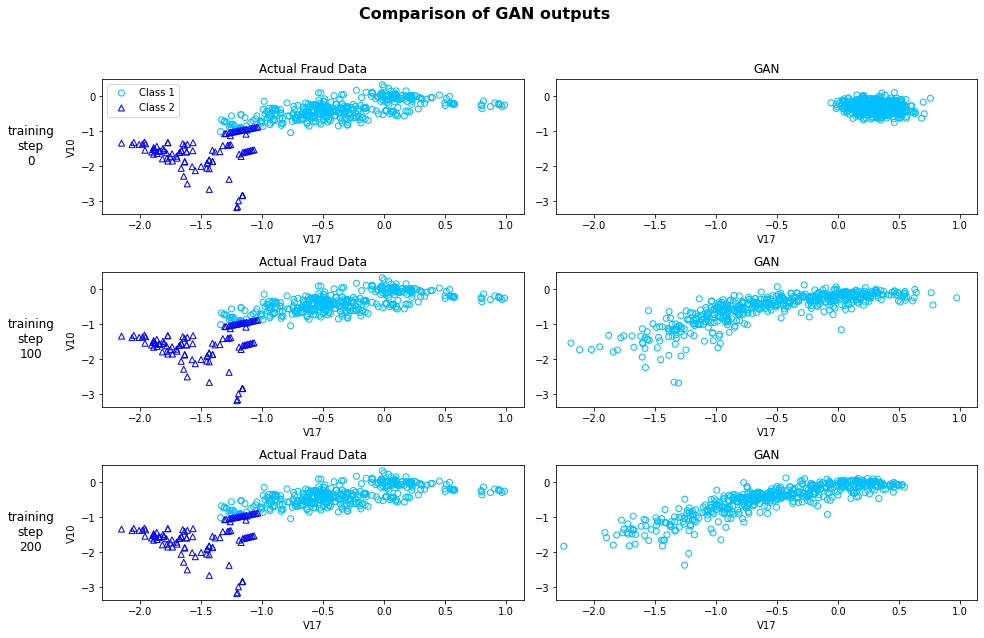

In [37]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv('./data/Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)

## Step 8: Inverse transform the data to obtain the original format

We notice that the generated synthetic data is still on the transformed form and needs to be inverse-transformed to the original format.

In [38]:
synthetic_data = inverse_transform(synthetic_fraud,preprocessor )

C:\Users\arunnt\Miniconda3\envs\synth\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"


In [39]:
synthetic_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,90892.210938,0.347208,0.193120,0.219038,0.030985,0.024854,-0.171526,0.017887,0.086508,-0.124982,...,-0.035176,-0.027605,0.008802,-0.013290,0.075231,0.006691,-0.054382,0.011940,-0.002109,19.850132
1,91160.078125,0.278046,0.102798,0.209108,-0.044689,-0.035106,-0.163478,0.053725,0.061579,-0.090636,...,-0.053148,-0.040601,-0.008149,-0.039121,0.083893,0.002123,-0.084565,0.005882,0.002793,23.191448
2,90343.726562,0.392732,0.198758,0.245832,0.159641,0.006378,-0.127572,-0.022030,0.101584,-0.126588,...,-0.018609,-0.022591,0.025349,-0.013803,0.089407,-0.006806,-0.038308,0.014012,-0.003001,17.822559
3,92951.187500,0.420300,0.182411,0.157024,0.088787,0.079302,-0.144119,0.014256,0.091671,-0.130646,...,-0.075082,-0.029856,-0.005410,-0.010332,0.066248,0.001441,-0.054135,0.019030,-0.007656,19.706913
4,87179.703125,0.372109,0.317210,0.179406,0.130793,-0.070776,-0.156429,-0.170158,0.112002,-0.211234,...,0.003515,0.011086,0.034202,-0.030137,0.073659,0.054488,-0.032405,0.045231,0.013694,15.272158


In [40]:
#Add back the class column
synthetic_data['Class']= 1

#Write the data for profiling
synthetic_data.to_csv('./data/creditcard_fraud_synthetic.csv', index=False)

## Step 9: Create a new checkpoint to validate the synthetic data against the real data

For the normal usage of Great Expectations, the best way to validate data is with a Checkpoint. Checkpoints bundle Batches of data with corresponding Expectation Suites for validation.

From the terminal, run the following command
```great_expectations --v3-api checkpoint new my_new_checkpoint```

This will again open a Jupyter Notebook that will allow you to complete the configuration of our Checkpoint. Edit the data_asset_name to reference the data we want to validate as "creditcard_fraud_synthetic.csv" (the file we wrote in step 8). Ensure that the expectation_suite_name is identical to what we created in step 4.

Once done, go ahead and execute all the cells in the notebook.

## Step 10: Evaluate the synthetic data using Data Docs

If you've following alone, you would have created the new checkpoint to validate the synthetic data. The last final step is to uncomment the final cell of the checkpoint notebook and execute it.

This will open up a HTML page titled Data Docs. We can inspect the Data Docs, for the most recent check point and see that the expectation has failed. By clicking on the checkpoint run, we get a detailed report of which expectations failed from which columns.

Based on this input we can do either of these actions:

- Go back to our synthesizer and tweak the parameters, optimize it to get better synthetic data
- Go back to the expectation suite and edit few expectations that is not important (maybe for certain columns). Yes - the expectations are customizable and here's how you can do it https://docs.greatexpectations.io/docs/guides/expectations/creating_custom_expectations/how_to_create_custom_expectations

# Conclusion

In this tutorial we have successfully demonstrated the use of ydata-synthetic alongside great expectations. A 10 step guide was presented starting from configuring a data context to evaluating the synthesized data using Data Docs. We believe an integration of the these two libraries can help data sciencetist unlock the power of synthetic data with data quality.